Loaded checkpoint from models/checkpoint.pth


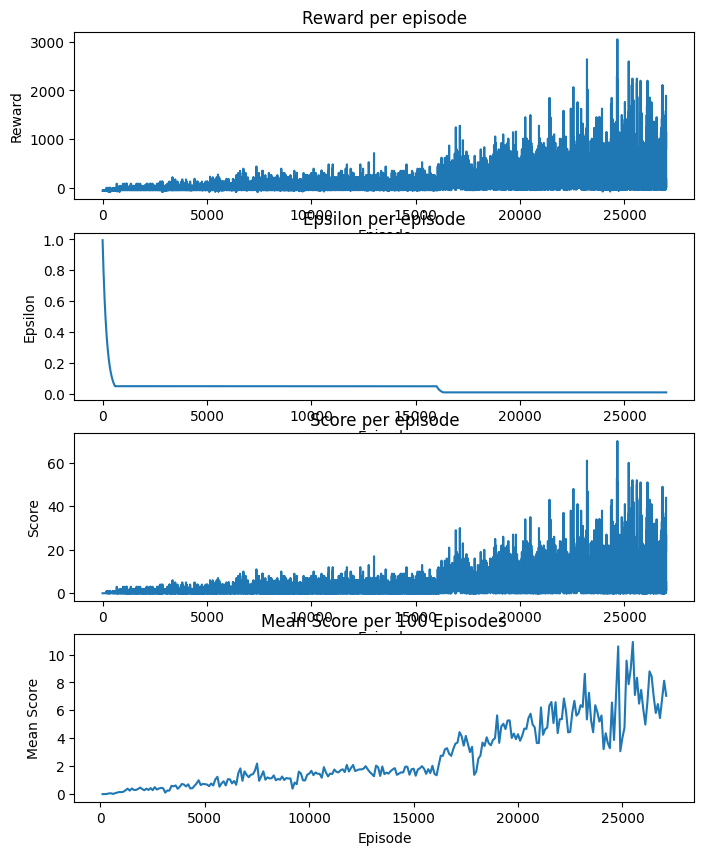

In [17]:

from src.config import ACTION_SIZE, STATE_SIZE
from src.agent import Agent

agent = Agent(STATE_SIZE, ACTION_SIZE)  
agent.display_chckpoint()